Creating batches of input and prediction by randomly sampling from songs.

In [37]:
import tensorflow as tf
from Audio.audio_parsing import load_waveform
import numpy as np

from model_utilities import display_batch_predictions, get_batch, int16_to_uint16, uint16_to_int16

samplerate, song_data, n_channels = load_waveform("../data/song.wav")

con = tf.constant(song_data)

x, y = get_batch(song_data, 10, 1, n_channels = 2, batch_offset = 1)

print("Raw predictions:")
display_batch_predictions(x, y, 2)
print("\nUInt16 predictions:")
display_batch_predictions(int16_to_uint16(x), int16_to_uint16(y), 2)


Raw predictions:
Input: [-19017 -15015] | Expected Output: [-18899 -15353]
Input: [-18899 -15353] | Expected Output: [-18125 -14913]

UInt16 predictions:
Input: [13751 17753] | Expected Output: [13869 17415]
Input: [13869 17415] | Expected Output: [14643 17855]


Creating the neural network.

In [3]:

# The vocab size for the encoded song values is the size of uint16. NOTE: Embeedings only work on positive values.
import keras

vocab_size = 2 ** 16
def build_model(embedding_dim: int = 256, rnn_units: int = 100, batch_size: int = 32):
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim);
    lstm_layer = keras.layers.LSTM(
        rnn_units, 
                                   return_sequences=True, recurrent_initializer='glorot_uniform', recurrent_activation='relu', stateful=True);
    dense_layer = keras.layers.Dense(vocab_size)
    
    return keras.Sequential(
        [
            embedding_layer,
            lstm_layer,
            dense_layer
        ]
    )

Let's see some example predictions on inputs: it's untrained, so it won't really do much. Another note is that embeddings only work on positive integers, so the signed int16 array of audio data points will need to be converted to uint16 and shifted accordingly.

In [3]:
batch_size = 32
x, y = get_batch(song_data, 100, batch_size, 2, 1)
x = uint16_to_int16(x).reshape(batch_size, -1)
y = uint16_to_int16(y).reshape(batch_size, -1)

model = build_model(256,1024, 32)
model.summary()

pred = tf.constant(model(x))
shape=(pred[0].shape[0], 1)
first = pred[0]

sampled_indices = tf.random.categorical(first, num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
print(sampled_indices)

# pred = tf.reshape(model(x), shape=(batch_size, int(pred.shape[1] / 2), 2))

# print(pred)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

[47440 39558 25907  8372 14319 49068 55106 56722 33550 31498 12703 41882
 20986 45854 43497 37648 16744  2255 63823 63105 54253 47577 49775 48294
 31185 18255 41291  5049   205 15487 34895 60912 58151 23505  2339 13665
 30639  7284 21850 49181 13778 16375 41580   165 52675  8479 60210 21265
 13631 33261 20276 62743 26025 28130 30124  9084 48840  4493 43382 58597
 19358 26686 64407 48091 12683 51875 21548 41257 34843 44946 35103 16316
 34296 38152 37648 55749  2460 46640 19181 42818 21349 62942 18481 18302
 41713  7101 28700 60642  3350 35648 45541  8200 24186  6259 12417 16950
 35102  4922 17766  1474 43338  2347 40996 51956 44681 41449 23397 13427
 50261 54279 43260 36853 13949  7191 45501 62483 13452 37029 42486 49927
 45557 63509 56798 37379  1131 17296 50051 47669 42605 61464 24385 15939
 30970 25847 61188 63234  7363 12686 58938   149 40153 34751 62955 52502
 56322 57645   876 51415  5187 36451 35285 49716 55044 28080 16197 13513
  3049 17760 57932 44417 26665 30295 52041 28203 50

Before actually training this model, I define the parameters in a convenient location for future experimentation and tweaking

Handling Optimization

Handling Loss

Next, we'll train the model on just one song to show that it's possible.

[]


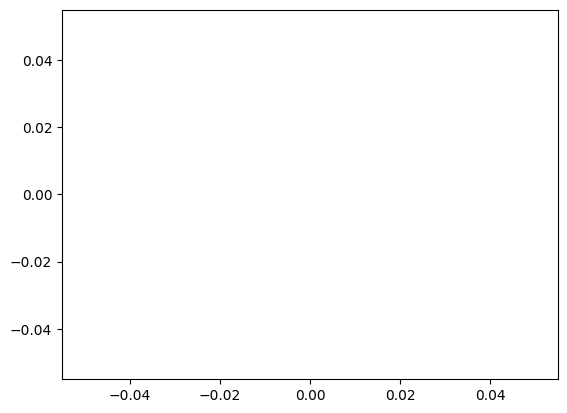

In [61]:

import os
import matplotlib.pyplot as plt
import tensorflow as tf
from model_utilities import get_batch, int16_to_uint16
import keras

training_params = {
    "learning_rate": 0.01,
    "epochs": 10,
    "batch_size": 32,
    "embedding_dim": 1,
    "rnn_units": 50,
    "sequence_length": 100,
    "song_channels": 2,
    "clip": 1.0
}


model = build_model(training_params["embedding_dim"],training_params["rnn_units"], training_params["batch_size"])

optimizer = keras.optimizers.Adam(learning_rate=training_params["learning_rate"], clipvalue=training_params["clip"])

def compute_loss(labels, logits):
  loss = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  # predicted = tf.argmax(logits, axis=2)
  # loss = keras.losses.mean_absolute_error(labels, predicted)
  return loss

# @tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss


history = []
xs = []
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt.weights.h5")
def train_model():
  xs = []
  history = []
  for i in range(training_params["epochs"]):
    x_batch, y_batch = get_batch(song_data, training_params["sequence_length"], training_params["batch_size"], training_params["song_channels"], 1)
    x_batch = tf.constant(int16_to_uint16(x_batch).reshape(training_params["batch_size"], -1), dtype=tf.uint16)
    y_batch = tf.constant(int16_to_uint16(y_batch).reshape(training_params["batch_size"], -1), dtype=tf.uint16)
    
    loss = train_step(x_batch, y_batch)
    np_loss = loss.numpy()
    history.append(np.average(np.average(np_loss, axis=1), axis=0))
    xs.append(i)
    
  model.save_weights(checkpoint_prefix)
# model.compile(optimizer=optimizer, loss=loss)

train_model()
print(history)
plt.scatter(xs, history, label="Loss")
plt.show()
# model.fit(x, y, epochs=10, batch_size=batch_size)

In [1]:
from Audio.audio_parsing import encode_waveform_to_song, load_waveform
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from model_utilities import get_batch, int16_to_uint16, uint16_to_int16
import keras

training_params = {
    "learning_rate": 0.01,
    "epochs": 10,
    "batch_size": 32,
    "embedding_dim": 1,
    "rnn_units": 50,
    "sequence_length": 100,
    "song_channels": 2,
    "clip": 1.0
}

# The vocab size for the encoded song values is the size of uint16. NOTE: Embeedings only work on positive values.
import keras

vocab_size = 2 ** 16
def build_model(embedding_dim: int = 256, rnn_units: int = 100, batch_size: int = 32):
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_dim);
    lstm_layer = keras.layers.LSTM(
        rnn_units, 
                                   return_sequences=True, recurrent_initializer='glorot_uniform', recurrent_activation='relu', stateful=True);
    dense_layer = keras.layers.Dense(vocab_size)
    
    return keras.Sequential(
        [
            embedding_layer,
            lstm_layer,
            dense_layer
        ]
    )

def compute_loss(labels, logits):
  loss = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  # predicted = tf.argmax(logits, axis=2)
  # loss = keras.losses.mean_absolute_error(labels, predicted)
  return loss

# @tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss




samplerate, song_data, n_channels = load_waveform("../data/song.wav")

n_samples = 10000
seed_set = int16_to_uint16(song_data[:n_samples])
shaped_seed_Set = tf.reshape(seed_set, shape=[int(2 * n_samples), 1])

model = build_model(training_params["embedding_dim"],training_params["rnn_units"], training_params["batch_size"])

optimizer = keras.optimizers.Adam(learning_rate=training_params["learning_rate"], clipvalue=training_params["clip"])

x_batch, y_batch = get_batch(song_data, training_params["sequence_length"], training_params["batch_size"], training_params["song_channels"], 1)
x_batch = tf.constant(int16_to_uint16(x_batch).reshape(training_params["batch_size"], -1), dtype=tf.uint16)
y_batch = tf.constant(int16_to_uint16(y_batch).reshape(training_params["batch_size"], -1), dtype=tf.uint16)

model.compile(optimizer=optimizer, loss=compute_loss)
model.fit(x_batch, y_batch, epochs=training_params["epochs"])

predictions = model.predict(shaped_seed_Set)
sampled_indices = tf.random.categorical(predictions, num_samples=1)
pred_channeled = uint16_to_int16(sampled_indices.numpy().reshape(-1, 2))

encode_waveform_to_song(pred_channeled, 44_100, "output.wav")

print(pred)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 11.0903
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 11.0739
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 11.0570
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 11.0400
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 11.0228
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 11.0056
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 10.9883
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 10.9710
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 10.9537
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 10.9363
  8182/176400 ━━━━━━━━━━━━━━━━━━━━ 9:44 3ms/step

ResourceExhaustedError: Graph execution error:

Detected at node sequential_1/dense_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\mdmoo\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\mdmoo\AppData\Local\Temp\ipykernel_51940\1141857385.py", line 74, in <module>

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 504, in predict

  File "c:\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 204, in one_step_on_data_distributed

  File "c:\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 194, in one_step_on_data

  File "c:\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 92, in predict_step

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Python312\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Python312\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Python312\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py", line 150, in call

  File "c:\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 3440, in matmul

  File "c:\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 481, in matmul

OOM when allocating tensor with shape[32,1,65536] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node sequential_1/dense_1/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_2775]

: 

First, we need to handle parsing all of the input labels that are available. Each song must be assigned a set of descriptive labels, which will then be embedded.

Next, we need to create predictive sets for out audio, encoding an input batch which predicts an output batch using random subsets of the songs that represent a set of labels.